
# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


In [2]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


In [3]:

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]


<Figure size 2100x1300 with 0 Axes>

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

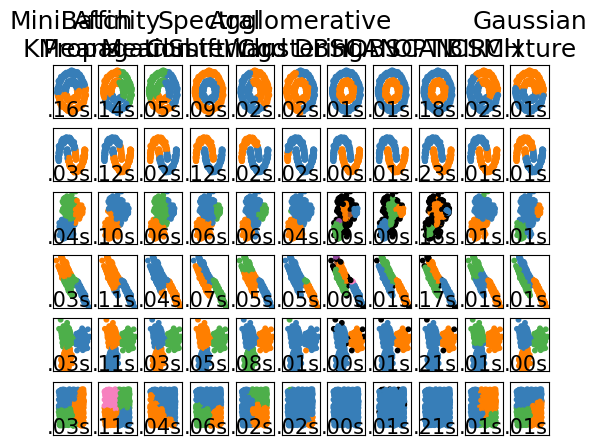

In [4]:

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

### MeanShift

**Method**:
- MeanShift identifies clusters by iteratively shifting points towards the mode of the data using a kernel density estimate. It works by initializing each point as its own cluster and then shifting each point towards the mean of the points within a given radius (bandwidth). This process is repeated until convergence, where points converge to the same peak (mode) and are assigned to the same cluster.

**Math**:
- **Bandwidth**: Radius of the kernel.
- **Update Rule**: $x_i^{(t+1)} = \frac{\sum_{x_j \in N(x_i, h)} K(x_j - x_i) x_j}{\sum_{x_j \in N(x_i, h)} K(x_j - x_i)}$

**Main Args**:
- `bandwidth`: Kernel bandwidth.
- `bin_seeding`: Whether to use bin seeding.

**Advantages**:
- Does not require the number of clusters.
- Can find arbitrarily shaped clusters.

**Disadvantages**:
- Computationally expensive.
- Sensitive to bandwidth parameter.


### MiniBatchKMeans

**Method**:
- MiniBatchKMeans is a variant of KMeans that uses mini-batches to reduce computation time, making it ideal for large datasets. It performs KMeans clustering on small, random subsets of the data, which significantly speeds up the convergence compared to traditional KMeans. This approach helps to handle large datasets more efficiently while providing results that are generally similar to the full-batch version.

**Math**:
- **Objective**: Minimize within-cluster sum of squares.
- **Update Rule**: Iteratively update centroids with mini-batches.

**Main Args**:
- `n_clusters`: Number of clusters.
- `random_state`: Seed for random number generator.

**Advantages**:
- Faster than KMeans for large datasets.
- Scalable.

**Disadvantages**:
- Requires the number of clusters.
- Sensitive to initial centroid selection.


### Agglomerative Clustering (Ward's Method)

**Method**:
- Agglomerative Clustering builds a hierarchy of clusters by merging pairs of clusters successively based on Ward's method, which minimizes the variance of the clusters being merged. It starts with each data point as its own cluster and iteratively merges the closest pair of clusters until the desired number of clusters is achieved.

**Math**:
- **Distance**: $d(A, B) = \sum_{i \in A \cup B} \| x_i - \mu_{A \cup B} \|^2$

**Main Args**:
- `n_clusters`: Number of clusters.
- `linkage`: Method of merging (ward in this case).
- `connectivity`: Connectivity matrix.

**Advantages**:
- Does not require the number of clusters upfront.
- Useful for hierarchical cluster visualization.

**Disadvantages**:
- Computationally expensive for large datasets.
- Sensitive to noise and outliers.


### Spectral Clustering

**Method**:
- Spectral Clustering uses the eigenvalues of the graph Laplacian to reduce dimensions before clustering in fewer dimensions. This method constructs a similarity graph of the data and performs clustering on this graph. The algorithm involves creating a graph Laplacian matrix, computing its eigenvalues and eigenvectors, and then applying KMeans on the reduced dimensional space formed by the top eigenvectors.

**Math**:
- **Graph Laplacian**: $L = D - A$, where $D$ is the degree matrix and $A$ is the adjacency matrix.
- **Eigen Decomposition**: Solve $L v = \lambda v$ and use the smallest eigenvectors for clustering.

**Main Args**:
- `n_clusters`: Number of clusters.
- `eigen_solver`: Solver for the eigen decomposition.
- `affinity`: Method to construct the affinity matrix.

**Advantages**:
- Can capture complex cluster structures.
- Effective for non-linearly separable data.

**Disadvantages**:
- Requires the number of clusters.
- Computationally expensive for large datasets.


### DBSCAN

**Method**:
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups together points that are closely packed and marks points as outliers that lie alone in low-density regions. It defines clusters as areas of high density separated by areas of low density. DBSCAN works by identifying core points (points with at least `min_samples` neighbors within `eps` radius) and expanding clusters from these core points.

**Math**:
- **Core Points**: Points with at least `min_samples` neighbors within `eps` radius.
- **Cluster Formation**: Density-reachable points are connected to form clusters.

**Main Args**:
- `eps`: Maximum distance for two points to be considered neighbors.
- `min_samples`: Minimum number of points to form a dense region.

**Advantages**:
- Does not require the number of clusters.
- Can find arbitrarily shaped clusters.
- Robust to noise and outliers.

**Disadvantages**:
- Performance depends on the choice of `eps` and `min_samples`.
- Not suitable for clusters with varying densities.


### HDBSCAN

**Method**:
- HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) extends DBSCAN by converting it into a hierarchical clustering algorithm and then condensing the hierarchy based on stability. It constructs a hierarchy of clusters using varying `eps` values and extracts the most stable clusters, allowing for the identification of clusters of varying densities.

**Math**:
- **Hierarchy Construction**: Builds a hierarchy of clusters.
- **Stability-based Extraction**: Selects clusters based on their stability over varying `eps`.

**Main Args**:
- `min_samples`: Minimum number of samples in a cluster.
- `min_cluster_size`: Minimum size of clusters.
- `allow_single_cluster`: Whether a single cluster is allowed.

**Advantages**:
- Does not require the number of clusters.
- Can find clusters of varying densities.
- More robust to parameter selection than DBSCAN.

**Disadvantages**:
- Computationally intensive.
- Interpretation of results can be complex.


### OPTICS

**Method**:
- OPTICS (Ordering Points To Identify the Clustering Structure) orders points to identify the clustering structure based on the density and distance to reach other points. It creates an ordering of the points that captures the density-based clustering structure, similar to DBSCAN but capable of finding clusters with varying densities.

**Math**:
- **Ordering Points**: Orders points based on their reachability distance.
- **Cluster Extraction**: Clusters are extracted from the reachability plot.

**Main Args**:
- `min_samples`: Minimum number of samples to form a cluster.
- `xi`: Minimum steepness on the reachability plot to define a cluster.
- `min_cluster_size`: Minimum size of clusters.

**Advantages**:
- Can find clusters of varying densities.
- Does not require a fixed `eps`.

**Disadvantages**:
- Computationally expensive.
- Parameter selection can be complex.


### Affinity Propagation

**Method**:
- Affinity Propagation identifies exemplars among the data points and forms clusters of data points around these exemplars through message passing. It works by simultaneously considering all data points as potential exemplars and exchanging messages between points to determine the optimal set of exemplars.

**Math**:
- **Similarity Matrix**: Defines the preference of points to be exemplars.
- **Message Passing**: Updates responsibility and availability messages iteratively.

**Main Args**:
- `damping`: Damping factor to avoid numerical oscillations.
- `preference`: Preferences for each point to be an exemplar.
- `random_state`: Seed for random number generator.

**Advantages**:
- Does not require the number of clusters.
- Can handle large datasets.

**Disadvantages**:
- Sensitive to preference parameter.
- Can be slow for large datasets.


### Agglomerative Clustering (Average Linkage)

**Method**:
- Average Linkage merges clusters based on the average distance between all pairs of points in the two clusters. It is a hierarchical clustering method that starts with each data point as its own cluster and merges the closest pairs of clusters iteratively until the desired number of clusters is achieved.

**Math**:
- **Distance**: $d(A, B) = \frac{1}{|A||B|} \sum_{a \in A} \sum_{b \in B} d(a, b)$

**Main Args**:
- `linkage`: Method of merging (average in this case).
- `metric`: Distance metric to use.
- `n_clusters`: Number of clusters.
- `connectivity`: Connectivity matrix.

**Advantages**:
- Suitable for capturing clusters with average similarities.
- Does not require the number of clusters upfront.

**Disadvantages**:
- Computationally expensive.
- Sensitive to noise and outliers.


### Birch

**Method**:
- BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) builds a tree structure from the data for efficient clustering. It incrementally and dynamically clusters incoming, multi-dimensional metric data points to maintain good clustering quality using limited resources.

**Math**:
- **CF Tree**: Clustering feature tree which summarizes the data.
- **Clustering Features**: Summarizes clusters using centroid, radius, and diameter.

**Main Args**:
- `n_clusters`: Number of clusters.
- `threshold`: Radius of the subclusters.

**Advantages**:
- Efficient for large datasets.
- Handles outliers by ignoring them in the initial passes.

**Disadvantages**:
- Requires the number of clusters.
- Performance depends on threshold value.


### Gaussian Mixture Model (GMM)

**Method**:
- GMM assumes that the data is a mixture of several Gaussian distributions and uses the Expectation-Maximization (EM) algorithm to find the parameters. It models the data as a combination of multiple Gaussian distributions, each representing a cluster, and iteratively refines the model to best fit the data.

**Math**:
- **Log-Likelihood**: Maximizes the log-likelihood of the data under the mixture model.
- **EM Algorithm**: Alternates between assigning points to clusters (E-step) and updating the cluster parameters (M-step).

**Main Args**:
- `n_components`: Number of Gaussian components (clusters).
- `covariance_type`: Type of covariance parameters to use (full, tied, diag, spherical).
- `random_state`: Seed for random number generator.

**Advantages**:
- Can model complex cluster shapes.
- Provides probabilistic cluster assignments.

**Disadvantages**:
- Requires the number of clusters.
- Computationally intensive for large datasets.
